# Predicting prevalence of hypertension on Zila level

## Notes

- Definition of diabetes:
    - Recommendation for diagnosis of hypertension [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4707193/)
- Hypertension if meets any of the following three criteria:
    - SBP ≥ 140 mmHg or DBP ≥ 90 mmHg
    - Told by a doctor to have high blood pressure (sh249)
    - Taking prescribed medicine to lower blood pressure (sh250)
    
- DHS Data
    - Three measurements of both systolic and diastolic blood pressure were taken during the survey at approximately 10-minute intervals between measurements.
    - The average of the second and third measurements was used to report respondent’s blood pressure values.
    - Arterial blood pressure is the force exerted by the blood on the wall of a blood vessel as the heart pumps (contracts) and relaxes. Systolic blood pressure (SBP) is the measures the force when the heart pumps (contracts), and the diastolic blood pressure (DBP) measures the degree of force when the heart is relaxes. The 2011 BDHS uses the American Heart Association guidelines for cut-off points for blood pressure measurements (AHA, 2003). The chart below summarizes the systolic and diastolic blood pressure values as they relate to hypertension classification. The cut-off points correspond to the clinical classification for hypertension as they relate to the systolic and diastolic blood pressure measurements.
   

## Packages

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import re
import glob
import logging
import itertools
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import pandas_ml as pd_ml
import matplotlib.pyplot as plt

%matplotlib inline
# import matplotlib.pylab as plt
# from matplotlib.pylab import rcParams

import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri

from scipy import io
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from datetime import timedelta
from datetime import datetime as dt

from dbfread import DBF

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Custom functions

In [2]:
def subset_by_var1(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var].notna(),:]
    print(df.shape)
    return df


def subset_by_var2(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var] != -9,:]
    print(df.shape)
    return df


def remove_metadata(input_df, metadata):
    df = input_df.copy(deep=True)
    var_select = [var1 for var1,var2 in zip(metadata['variable'],metadata['model_keep']) if var2 == 0]
    print(df.shape)
    df = df.drop(var_select, axis=1)
    print(df.shape)
    return df 
 
def remove_uniform(input_df):
    df = input_df.copy(deep=True)
    var_list = []
    for key, var in enumerate(df):
        tmp = df[var].dropna()
        if len(tmp.unique()) == 1:
            var_list.append(var)
    print(df.shape)
    print(var_list)
    df = df.drop(var_list, axis=1)
    print(df.shape)
    return df
    
def remove_identical(input_df):
    df = input_df.copy(deep=True)
    var_pairs_check = []
    var_pairs = []
    for pair in itertools.combinations(list(df.columns),2):
        var_pairs.append(pair)
        var_pairs_check.append(all(df[pair[0]] == df[pair[1]]))
    selected_pairs = [pair for pair, check in zip(var_pairs, var_pairs_check) if check]
    selected_var = [var2 for var1,var2 in selected_pairs]
    print(df.shape)
    df = df.drop(list(set(selected_var)), axis=1)
    print(df.shape)
    return df


def remove_missing(input_df, threshold):
    df = input_df.copy(deep=True)
    drop_vars = []
    for key, var in enumerate(df):
        null_percent = round(df[var].isnull().mean() * 100,2)
        if null_percent >= threshold:
            drop_vars.append(var)
    print(df.shape)
    df = df.drop(drop_vars, axis=1)
    print(df.shape)
    return df


def check_variables(input_df):
    df = input_df.copy(deep=True)
    var_types = [var_n for var_t,var_n  in zip(df.dtypes, df.columns) if var_t == 'O']
    return var_types

def summarize_variables(input_df, metadata_df):
    metadata = metadata_df.copy(deep=True)
    metadata['num_values'] = 'NaN'
    for key, var in enumerate(metadata.values):
        metadata.loc[key,'num_values'] = len(input_df[var[0]].unique())
    return metadata


def determine_hypertension(input_df, option):
    df = input_df.copy(deep=True)
    df['hypertension'] = -9
    for key, value in enumerate(df.values):
        if option == 'valid':
            if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or df.loc[key,'fsysto'] >= 140. or df.loc[key,'fdysto'] >= 90.):
                df.at[key, 'hypertension'] = 1
            elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or df.loc[key,'fsysto'] < 140 or df.loc[key,'fdysto'] < 90):
                df.at[key, 'hypertension'] = 0
            else:
                df.at[key,'hypertension'] = -9
        elif option == 'average':
            syst = np.mean([df.loc[key,'sh255s'],df.loc[key,'sh264s']])
            dyst = np.mean([df.loc[key,'sh255d'],df.loc[key,'sh264d']])
            if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or syst >= 140. or dyst > 90.):
                df.at[key, 'hypertension'] = 1
            elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or syst < 140. or dyst < 90.):
                df.at[key, 'hypertension'] = 0
            else:
                df.at[key,'hypertension'] = -9
    return df  

def determine_hyperglycaemia(input_df):
    df = input_df.copy(deep=True)
    df['sh280'] = np.where(df['sh280'].isna(), 9999, df['sh280'])
    df['sh280'] = df['sh280'].astype(int).astype(str)
    df['meal'] = 1
    for key,time in enumerate(df['sh280']):
        try:
            df.at[key,'meal'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'meal'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh281'] = np.where(df['sh281'].isna(), 9999, df['sh281'])
    df['sh281'] = df['sh281'].astype(int).astype(str)
    df['drink'] = 1
    for key,time in enumerate(df['sh281']):
        try:
            df.at[key,'drink'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'drink'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh283t'] = np.where(df['sh283t'].isna(), 9999, df['sh283t'])
    df['sh283t'] = df['sh283t'].astype(int).astype(str)
    df['measure_time'] = 1
    for key,time in enumerate(df['sh283t']):
        try:
            df.at[key,'measure_time'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'measure_time'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    df['meal'] = pd.to_datetime(df['meal'], format='%Y-%m-%d %H:%M:%S')
    df['drink'] = pd.to_datetime(df['drink'], format='%Y-%m-%d %H:%M:%S')
    df['measure_time'] = pd.to_datetime(df['measure_time'], format='%Y-%m-%d %H:%M:%S')
    df['meal_delta'] = df['meal'] - df['measure_time']
    df['meal_delta'] = df['meal_delta']/np.timedelta64(1,'h')
    df['meal_fasting'] = np.where(df['meal_delta'] > 4, 1, 0)
    df['drink_delta'] = df['drink'] - df['measure_time']
    df['drink_delta'] = df['drink_delta']/np.timedelta64(1,'h')
    df['drink_fasting'] = np.where(df['drink_delta'] > 4, 1, 0)
    df['hyperglycaemia'] = -9
    # sh258: Ever told by a doctor/nurse to have diabetes
    # sh259: Taking medication for the diabetes
    # df.loc[key,'drink_fasting'] == 1. and df.loc[key,'meal_fasting'] == 1. and 
    # df.loc[key,'drink_fasting'] == 0. and df.loc[key,'meal_fasting'] == 0. and 
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh284b'] >= 126 or df.loc[key,'sh258'] == 1 or df.loc[key,'sh259'] == 1):
            df.at[key, 'hyperglycaemia'] = 1
        elif (df.loc[key,'sh284b'] < 126 or df.loc[key,'sh258'] == 0 or df.loc[key,'sh259'] == 0):
            df.at[key, 'hyperglycaemia'] = 0
        else:
            df.at[key, 'hyperglycaemia'] = -9
    return df 


def to_categorical(input_df, input_meta):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if str(input_meta[input_meta['variable'] == var].values[0][4]) == 'categorical':
            df[var] =  df[var].astype('str').astype('category')
    return df

def threshold_cut(input_df, threshold):
    df = input_df.copy(deep=True)
    df = df.sort_values(by='importance', ascending=False)
    df['cumsum'] = np.cumsum(df['importance'])
    df = df[df['cumsum'] >= threshold]
    return df

def read_svrs(path, pattern):
    data = {}
    for path, subdir, files in os.walk(path):
        for file in files:
            if file.endswith(pattern):
                itr = pd.read_stata(os.path.join(path,file), iterator=True)
                variables = list(itr.variable_labels().values())
                data[file] = pd.read_stata(os.path.join(path,file))
                data[file].columns = variables
    return data

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_svrs(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = list(data.columns)
    data.columns = variables
    return data, original_variables

def eer_threshold(model, test_X, test_y):
    predictions = model.predict_proba(test_X)
    predictions = predictions[:,1]
    output = {}
    for i in range(5,100,1):
        y_predicted = np.where(predictions > i/100, 1, 0)
        cm = confusion_matrix(y_pred=y_predicted, y_true=test_y,)
        tn, fp, fn, tp = cm.ravel()
        n = test_y.value_counts()[0]
        p = test_y.value_counts()[1]
        precision = tp / (tp + fp) # positive predictive value
        recall = tp / (tp + fn) # true positive rate
        output[str(i/100)] = precision-recall
    output = pd.DataFrame.from_dict(output,orient='index', columns=['EER'])
    output['EER'] = np.absolute(output['EER'])
    output = output.sort_values(by='EER', ascending=True)
    display(output.head(10))
    return float(output.index[0]), output.iloc[0,0],


def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Hypertension'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(f"Accuracy : %.4g {accuracy_score(dtrain['Hypertension'].values, dtrain_predictions)}")
    print(f"AUC Score (Train): {roc_auc_score(dtrain['Hypertension'], dtrain_predprob)}]")
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = X_data_test.merge(dtest[['predprob']])
    print(f"AUC Score (Test): {roc_auc_score(results['Hypertension'], results['predprob'])}")
    print(alg.booster)
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Variables

In [3]:
NCD_DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/data_dd_dhs_ncd.csv'
c = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd.csv'
METADATA_M = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd_m.csv'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/'

SVRS2017_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/metadata_bbs_SRVS_17.csv'
SVRS2013_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/metadata_bbs_SRVS_13.csv'
SVRS2014_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/metadata_bbs_SRVS_14.csv.csv'

SVRS2012 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_12/tafsil-2p.dbf'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/pop_hh_14-05-2015.sav'
SVRS2014 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/tafsil2P_12-06-2015.sav'
SVRS2015 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_15/tafsil-2p.dbf'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/tafsl-2p.dta'

### Reading data

In [4]:
ncd_data = pd.read_csv(NCD_DATA)
ncd_metadata = pd.read_csv(METADATA_M)

### Creating hypertension target variable

In [5]:
# ncd_data = determine_hypertension(input_df=ncd_data, option='valid')
# print(ncd_data['hypertension'].value_counts())

In [6]:
ncd_data = determine_hypertension(input_df=ncd_data, option='average')
print(ncd_data['hypertension'].value_counts())

-9    75739
 0     5644
 1     2348
Name: hypertension, dtype: int64


In [7]:
ncd_metadata = summarize_variables(input_df=ncd_data, metadata_df=ncd_metadata)
ncd_metadata.head()
ncd_metadata.to_csv(METADATA_M, index=False, index_label=False)

In [8]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shbm,shri,shcmc,shflg,shsmk,shresi,shed1,shed2,shed3,hypertension
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9


In [9]:
ncd_metadata.head()

,variable,description,model_keep,num_values,type
0,hhid,Case Identification,0,17141,numeric
1,hvidx,Line number,0,31,categorical
2,hv000,Country code and phase,0,1,categorical
3,hv001,Cluster number,0,600,categorical
4,hv002,Household number,0,184,categorical


In [10]:
for num, var in enumerate(ncd_metadata['description']):
    if "blood pressure" in var:
        print(ncd_metadata['variable'][num], ncd_metadata['description'][num])

sh19 Eligible for blood glucose and blood pressure tests: Woman
sh20 Eligible for height, weight,blood glucose and blood pressure tests: Woman
sh22 Eligible for height,weight,blood glucose and blood pressure tests:Man
sh241 Consent for blood pressure measurement
sh244 Arm Circumference measurement for blood pressure
sh245 Time for first blood pressure test
sh246s Systolic blood pressure measurement
sh246d Diastolic blood pressure measurement
sh249 Told by a doctor to have high blood pressure
sh250 Taking prescribed medicine to lower blood pressure
sh253 Time for second blood pressure test
sh254 Consent for second blood pressure test
sh255s Systolic blood pressure
sh255d Diastolic blood pressure
sh262 Time for third blood pressure test
sh263 Consent for third blood pressure test
sh264s Systolic blood pressure
sh264d Diastolic blood pressure
fdysto Valid Dystolic blood pressure


In [11]:
for num, var in enumerate(ncd_metadata['description']):
    if "tolic blood pressure" in var:
        print(ncd_metadata['variable'][num], ncd_metadata['description'][num])

sh246s Systolic blood pressure measurement
sh246d Diastolic blood pressure measurement
sh255s Systolic blood pressure
sh255d Diastolic blood pressure
sh264s Systolic blood pressure
sh264d Diastolic blood pressure
fdysto Valid Dystolic blood pressure


### Subset data by target variable missingness

In [12]:
data = subset_by_var2(input_df=ncd_data, var='hypertension')
'hypertension' in data.columns

(83731, 384)
(7992, 384)


True

### Subset data by metadata file (variables to keep column)

In [13]:
data = remove_metadata(input_df=data, metadata=ncd_metadata)
'hypertension' in data.columns

(7992, 384)
(7992, 307)


True

### Remove uniformed variables (no variation)

In [14]:
data = remove_uniform(input_df=data)
'hypertension' in data.columns

(7992, 307)
['hv015', 'hv020', 'hv027', 'hv042', 'hv120', 'hv121', 'hv122', 'hv124', 'sh21', 'ha62', 'hb62']
(7992, 296)


True

### Removing missing by threshold 

In [15]:
data = remove_missing(input_df=data, threshold=1)
'hypertension' in data.columns

(7992, 296)
(7992, 102)


True

### Checking variables

In [16]:
check_variables(input_df=data)

[]

### Removing meta variables

In [17]:
data = data.drop(['Unnamed: 0'],axis=1)
data.head()

,hv009,hv010,hv011,hv012,hv013,hv014,hv016,hv017,hv024,hv025,...,sh234c,sh237,sh239,sh241,sh257,shwh,shcmc,shed1,shed3,hypertension
16,6,0,0,6,2,1,10,1,1,2,...,58.0,0.0,0.0,1.0,1.0,0.0,642.0,0.0,0.0,0
17,6,0,0,6,2,1,10,1,1,2,...,60.0,1.0,13.0,1.0,1.0,3.0,614.0,1.0,1.0,1
26,5,1,1,5,5,1,10,1,1,2,...,36.0,1.0,52.0,1.0,1.0,0.0,907.0,1.0,1.0,0
39,2,0,0,2,2,0,10,1,1,2,...,65.0,0.0,13.0,1.0,1.0,3.0,556.0,0.0,0.0,1
40,2,0,0,2,2,0,10,1,1,2,...,55.0,0.0,0.0,1.0,1.0,0.0,669.0,0.0,0.0,0


# Predictors
- **Education (completed in years)**
    1. DHS: **hv108** - Education completed in single years
    2. SVRS2017: **q_16** - Level of Education
- **Age**
    1. DHS: **hv105** - Age of household members
    2. SVRS2017: **q_10** - Age
- **Urban/rural**
    1. DHS: 'hv025'
    2. SVRS2017: 'Rural/Urban' / 'rmo'
- **Sex**
    1. DHS:'hv104'
    2. SVRS2017: 'Sex'

In [18]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
orig_data = data[['hv108', 'hv105', 'hv025', 'hv104', 'hypertension']]
orig_data.columns = variables + ['Hypertension']
orig_data = orig_data[orig_data['Education'] != 98]
orig_data = orig_data[orig_data['Education'] != 97]
orig_data = orig_data[orig_data['Hypertension'] != 9]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data.head()

,Education,Age,Urban/Rural,Gender,Hypertension
16,0,58,2,2,0
17,3,60,2,1,1
26,2,36,2,1,0
39,0,65,2,1,1
40,0,55,2,2,0


### DHS Codes	New Codes Categorisation 1
- 0		No education [0]
- 1		Primary Education [1]
- 2		Primary Education [1]
- 3		Primary Education [1]
- 4		Primary Education [1]
- 5		Primary Education [1]
- 6		Secondary Education [2]
- 7		Secondary Education [2]
- 8		Secondary Education [2]
- 9		Secondary Education [2]
- 10	Secondary Education [2]
- 11	Higher Secondary Education [3]
- 12	Higher Secondary Education [3]
- 13	Undergraduate and more [4]
- 14	Undergraduate and more [4]
- 15	Undergraduate and more [4]
- 16	Undergraduate and more [4]
- 17	Undergraduate and more [4]
- 18	Undergraduate and more [4]
- 97	Remove [-1]
- 98	Remove [-1]

### DHS Codes	New Codes Categorisation 2
- **0** [No education]: 0
- **1,2,3,4** [Primary incomplete]: 1
- **5** [Completed primary]: 2
- **6,7,8,9** [Secondary incomplete]: 3
- **10** [Completed secondary]: 4
- **11-18** [More than secondary]: 5
- **97** [Missing]: Remove
- **98** [Missing]: Remove

In [19]:
edu_categorisation_1 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i >= 11 and i <= 12):
        edu_categorisation_1.append(3)
    elif (i >= 13 and i <= 18):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 3733, 1: 2128, 2: 1491, 4: 366, 3: 274})
0     3733
1      236
2      355
3      295
4      413
5      829
6      149
7      214
8      306
9      420
10     402
11       7
12     267
13       2
14     170
15      50
16     110
17      31
18       3
Name: Education, dtype: int64


In [20]:
edu_categorisation_2 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 18):
        edu_categorisation_2.append(5)
    elif (i == 97 or i == 98):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_2))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 3733, 1: 1299, 3: 1089, 2: 829, 5: 640, 4: 402})
0     3733
1      236
2      355
3      295
4      413
5      829
6      149
7      214
8      306
9      420
10     402
11       7
12     267
13       2
14     170
15      50
16     110
17      31
18       3
Name: Education, dtype: int64


In [21]:
orig_data['Urban/Rural'] = orig_data['Urban/Rural'].astype('category')
orig_data['Gender'] = orig_data['Gender'].astype('category')
orig_data['Education_1'] = edu_categorisation_1
orig_data['Education_1'] = orig_data['Education_1'].astype('category')
orig_data['Education_2'] = edu_categorisation_2
orig_data['Education_2'] = orig_data['Education_2'].astype('category')
y = orig_data['Hypertension']
X = orig_data.drop(['Hypertension', 'Education', 'Education_1'], axis=1)
# X = orig_data.drop(['Hypertension', 'Education', 'Education_2'], axis=1)
X.dtypes
X = pd.get_dummies(X)
X.dtypes

Age              int64
Urban/Rural_1    uint8
Urban/Rural_2    uint8
Gender_1         uint8
Gender_2         uint8
Education_2_0    uint8
Education_2_1    uint8
Education_2_2    uint8
Education_2_3    uint8
Education_2_4    uint8
Education_2_5    uint8
dtype: object

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=84)

# Fine-tuning the model - Hypertension

In [23]:
X_data_train = X_train.copy(deep=True)
X_data_train['Hypertension'] = y_train
X_data_test = X_test.copy(deep=True)
X_data_test['Hypertension'] = y_test


Model Report
Accuracy : %.4g 0.7300172063194118
AUC Score (Train): 0.709751404186238]
AUC Score (Test): 0.7007332945154999
gbtree


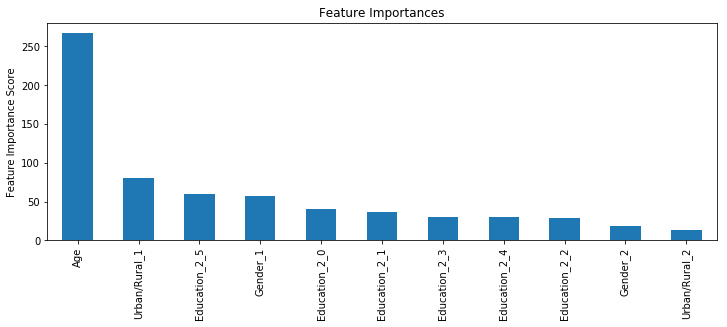

In [24]:
plt.rcParams['figure.figsize'] = 12, 4
target = 'Hypertension'
predictors = [x for x in X_data_train.columns if x not in [target]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb1, X_data_train, X_data_test, predictors)

## Grid seach on n_estimators: Initial step

In [ ]:
param_test0 = {
    'n_estimators':range(10,1000,100)
}
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0.fit(X_train,y_train)

In [ ]:
#gsearch0.cv_results_,gsearch0.best_params_, gsearch0.best_score_
print("#"*100)
print(gsearch0.best_params_)
print(gsearch0.best_score_)
print("#"*100)

In [ ]:
param_test0a = {
    'n_estimators':range(2,10,1)
}
gsearch0a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0a, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0a.fit(X_train,y_train)

In [ ]:
#gsearch0a.cv_results_,gsearch0a.best_params_, gsearch0a.best_score_
print("#"*100)
print(gsearch0a.best_params_)
print(gsearch0a.best_score_)
print("#"*100)

## Grid seach on max_depth and min_child_weight: Initial step

In [ ]:
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(X_train,y_train)

In [ ]:
#gsearch1.cv_results_,gsearch1.best_params_, gsearch1.best_score_
print("#"*100)
print(gsearch1.best_params_)
print(gsearch1.best_score_)
print("#"*100)

## Grid seach on max_depth and min_child_weight: Step 2

In [ ]:
param_test2 = {
    'max_depth':[3,4,5,6,7],
    'min_child_weight':[4,5,6,7,8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(X_train,y_train)

In [ ]:
# gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_
print("#"*100)
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print("#"*100)

## Grid seach on max_depth and min_child_weight: Double check

In [ ]:
param_test3 = {
    'max_depth':[3,4,5,6,7],
    'min_child_weight':[4,5,6,7,8]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(X_train,y_train)

In [ ]:
#gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_
print("#"*100)
print(gsearch3.best_params_)
print(gsearch3.best_score_)
print("#"*100)


## Grid seach on gamma: Initial step

In [ ]:

#Choose all predictors except target & IDcols
param_test4 = {
    'gamma':[0,1,5] + [i/10.0 for i in range(0,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(X_train,y_train)

In [ ]:
# gsearch4.cv_results_,gsearch4.best_params_, gsearch4.best_score_
print("#"*100)
print(gsearch4.best_params_)
print(gsearch4.best_score_)
print("#"*100)

# Evaluate importance and accuracy

In [ ]:
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=8,
        max_depth=5,
        min_child_weight=6,
        gamma=0.7,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb2, X_data_train, X_data_test, predictors)

## Grid seach on subsample and colsample_bytree: Initial step

In [ ]:
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0.7, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(X_train,y_train)

In [ ]:
#gsearch5.cv_results_,gsearch5.best_params_, gsearch5.best_score_
print("#"*100)
print(gsearch5.best_params_)
print(gsearch5.best_score_)
print("#"*100)


## Grid seach on subsample and colsample_bytree: Fine-tune

In [ ]:
#Choose all predictors except target & IDcols
param_test6 = {
    'subsample':[i/100.0 for i in range(65,100,5)],
    'colsample_bytree':[i/100.0 for i in range(55,90,5)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0.7, subsample=0.8, colsample_bytree=0.7,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(X_train,y_train)

In [ ]:
#gsearch6.cv_results_,gsearch6.best_params_, gsearch6.best_score_
print("#"*100)
print(gsearch6.best_params_)
print(gsearch6.best_score_)
print("#"*100)

## Grid seach on reg_alpha: Initial step

In [ ]:
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0.7, subsample=0.65, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(X_train,y_train)

In [ ]:
#gsearch7.cv_results_,gsearch7.best_params_, gsearch7.best_score_
print("#"*100)
print(gsearch7.best_params_)
print(gsearch7.best_score_)
print("#"*100)

## Grid seach on reg_alpha: Fine-tune

In [ ]:
# Choose all predictors except target & IDcols
param_test8 = {
    'reg_alpha':[0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=6, gamma=0.7, subsample=0.65, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(X_train,y_train)

In [ ]:
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_
print("#"*100)
print(gsearch8.best_params_)
print(gsearch8.best_score_)
print("#"*100)


Model Report
Accuracy : %.4g 0.7232910996402315
AUC Score (Train): 0.7024127111356933]
AUC Score (Test): 0.7073511575705644
gbtree


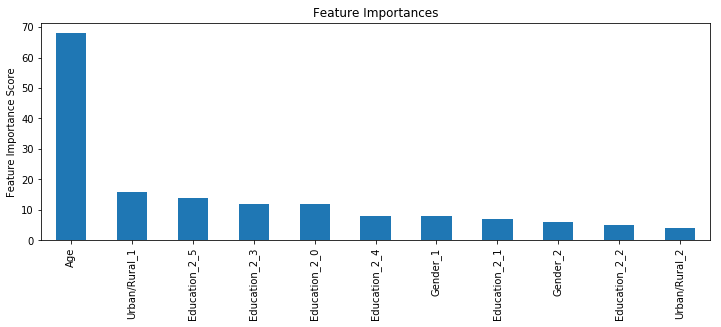

In [25]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=8,
        max_depth=5,
        min_child_weight=6,
        gamma=0.7,
        subsample=0.65,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb3, X_data_train, X_data_test, predictors)

In [26]:
tr = eer_threshold(model=xgb3,test_X=X_test, test_y=y_test)
tr

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: RuntimeWarning: invalid value encountered in long_scalars


,EER
0.42,0.027398
0.41,0.067596
0.43,0.071281
0.4,0.122426
0.44,0.141762
0.39,0.160422
0.45,0.174705
0.46,0.224754
0.47,0.249733
0.38,0.263555


(0.42, 0.02739784215444735)

0.027587519025875182


0.06565005727376863

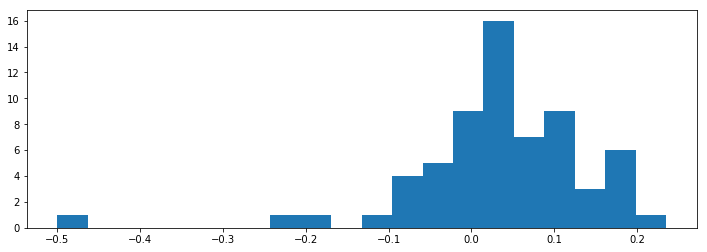

In [27]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.42, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

0.021029731689630182


0.03466366301976584

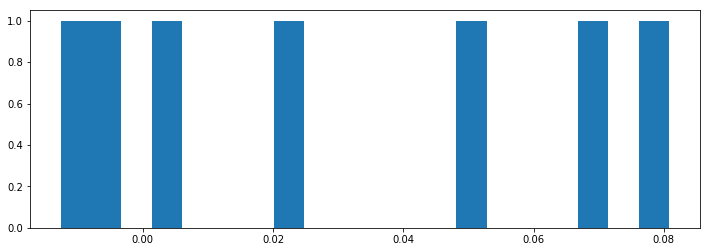

In [28]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.42, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [29]:
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.42, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm2)

[[893 232]
 [259 215]]


In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1125
           1       0.48      0.45      0.47       474

   micro avg       0.69      0.69      0.69      1599
   macro avg       0.63      0.62      0.63      1599
weighted avg       0.69      0.69      0.69      1599



#################################################################################################################
#################################################################################################################
#################################################################################################################

# Predicting hypertension prevalence using SVRS 2013, 2014 and 2017 data

- SVRS 2012: DBF
- SVRS 2013: SAV
- SVRS 2014: SAV
- SVRS 2015: DBF
- SVRS 2017: DTA

### SVRS Codes	New Codes Categorisation 1
- **Did not passed 1st grade** 0 [No education]: 0	
- **Passed 1st grade**	1	[Primary Education]: 1
- **Passed 2nd grade**	2	[Primary Education]: 1
- **Passed 3rd grade**	3	[Primary Education]: 1
- **Passed 4th grade**	4	[Primary Education]: 1
- **Passed 5th grade**	5	[Primary Education]: 1
- **Passed 6th grade**	6	[Secondary Education]: 2
- **Passed 7th grade**	7	[Secondary Education]: 2
- **Passed 8th grade**	8	[Secondary Education]: 2
- **Passed 9th grade**	9	[Secondary Education]: 2
- **Secondery or equal**	10	[Secondary Education]: 2
- **Higher secondary or equal**	11	[Higher Secondary Education]: 3
- **Undergraduate or equal**	12	[Undergraduate and more]: 4
- **Graduate or equal**	13	[Undergraduate and more]: 4
- **Doctor/Engineer/Agriculturist**	14	[Undergraduate and more]: 4
- **Diploma**	15	[Undergraduate and more]: 4
- **Vocational**	16	[Higher Secondary Education]: 3
- **Others**	17	[Remove]: -1

### SVRS Codes	New Codes Categorisation 2
- **Did not passed 1st grade**	0	[No education]: 0
- **Passed 1st grade**	1	[Primary incomplete]: 1
- **Passed 2nd grade**	2	[Primary incomplete]: 1
- **Passed 3rd grade**	3	[Primary incomplete]: 1
- **Passed 4th grade**	4	[Primary incomplete]: 1
- **Passed 5th grade**	5	[Completed primary]: 2
- **Passed 6th grade**	6	[Secondary incomplete]: 3
- **Passed 7th grade**	7	[Secondary incomplete]: 3
- **Passed 8th grade**	8	[Secondary incomplete]: 3
- **Passed 9th grade**	9	[Secondary incomplete]: 3
- **Secondery or equal**	10	[Completed secondary]: 4
- **Higher secondary or equal**	11	[More than secondary]: 5
- **Undergraduate or equal**	12	[More than secondary]: 5
- **Graduate or equal**	13	[More than secondary]: 5
- **Doctor/Engineer/Agriculturist**	14	[More than secondary]: 5
- **Diploma**	15	[More than secondary]: 5
- **Vocational**	16	[More than secondary]: 5
- **Others**	17	[Remove]: -1

## SVRS2012

In [31]:
data_svrs2012r = read_dbf(SVRS2012)
data_svrs2012r = data_svrs2012r[data_svrs2012r['Q_16'] != 99]
data_svrs2012r['RMO'] = np.where(data_svrs2012r['RMO'] != '1', 2, 1) # Urban=1, Rural=2
data_svrs2012r['RMO'] = data_svrs2012r['RMO'].astype(int).astype('category')
data_svrs2012r['Q_12'] = data_svrs2012r['Q_12'].astype(int).astype('category') # Male=1, Female=2
data_svrs2012r = data_svrs2012r[data_svrs2012r['Q_11'] >= 35]


In [32]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2012 = data_svrs2012r[['Q_16', 'Q_11', 'RMO', 'Q_12']]
data_svrs2012.columns = variables

In [33]:
print(data_svrs2012r.shape)
print(data_svrs2012.shape)

(366585, 27)
(366585, 4)


In [34]:
print(data_svrs2012['Education'].value_counts().sort_index())

0     176475
1       3913
2      12493
3      10979
4      11243
5      46627
6       8215
7       7746
8      17188
9      16985
10     23032
11     11686
12     12949
13      5034
14      1261
15       389
16       370
Name: Education, dtype: int64


In [35]:
edu_categorisation_1 = []
for i in data_svrs2012['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))

Counter({0: 176475, 1: 85255, 2: 73166, 4: 19633, 3: 12056})


In [36]:
edu_categorisation_2 = []
for i in data_svrs2012['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))
print(data_svrs2012['Education'].value_counts().sort_index())

Counter({0: 176475, 3: 50134, 2: 46627, 1: 38628, 5: 31689, 4: 23032})
0     176475
1       3913
2      12493
3      10979
4      11243
5      46627
6       8215
7       7746
8      17188
9      16985
10     23032
11     11686
12     12949
13      5034
14      1261
15       389
16       370
Name: Education, dtype: int64


In [37]:
# data_svrs2012['Education_1'] = edu_categorisation_1
# data_svrs2012['Education_1'] = data_svrs2012['Education_1'].astype('category')
data_svrs2012['Education_2'] = edu_categorisation_2
data_svrs2012['Education_2'] = data_svrs2012['Education_2'].astype('category')
data_svrs2012 = data_svrs2012.drop(['Education'], axis =1)
data_svrs2012 = pd.get_dummies(data_svrs2012)
data_svrs2012.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,60,1,0,1,0,0,0,0,0,1,0
1,41,1,0,0,1,0,0,0,1,0,0
4,48,1,0,1,0,0,0,1,0,0,0
5,41,1,0,0,1,0,0,0,1,0,0
9,61,1,0,0,1,0,1,0,0,0,0


## SVRS2013

In [38]:
data_svrs2013r = read_sav(SVRS2013)
print(data_svrs2013r.shape)
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q16'].notna()]
print(data_svrs2013r.shape)
print("\n")
print("#"*100)
print(data_svrs2013r['RMO'].value_counts().sort_index())
print(data_svrs2013r['Q12'].value_counts().sort_index())
print("#"*100)
print("\n")
data_svrs2013r['Q16'] = data_svrs2013r['Q16'].astype('category')
print(data_svrs2013r['Q16'].value_counts())
data_svrs2013r['Q16'] = data_svrs2013r['Q16'].cat.rename_categories({'None':0, 'Class I passed':1, 'Class II passed':2,
 'Class III passed':3, 'Class IV passed':4, 'Class V passed':5,
 'Class VI passed':6, 'Class VII passed':7, 'Class VIII passed':8,
 'Class IXpassed':9, 'SSC or equvalent': 10, 'HSC or equvalent':11,
 'Degree or equvalent':12, 'Masters or equvalent':13, 'Doctor.Engineer/Krishibid':14,
 'Diploma':15, 'Vocational':16, 'Other':99})
data_svrs2013r['Q16'] = data_svrs2013r['Q16'].astype(int)
print(data_svrs2013r['Q16'].value_counts())
print(data_svrs2013r.shape)
print("#"*100)
print("\n")
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q11'] >= 35]
print(data_svrs2013r.shape)
print("#"*100)
print("\n")
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q16'] != 99]
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q11'] != 99.0]
data_svrs2013r['RMO'] = np.where(data_svrs2013r['RMO'] != 'Rural', 2, 1)
data_svrs2013r['RMO'] = data_svrs2013r['RMO'].astype(int).astype('category')
data_svrs2013r['Q12'] = np.where(data_svrs2013r['Q12'] != 'Male', 1, 2)
data_svrs2013r['Q12'] = data_svrs2013r['Q12'].astype(int).astype('category')
print(data_svrs2013r.shape)

(692763, 44)
(613023, 44)


####################################################################################################
City corporation    124910
Municipality        102166
Rural               338314
Upazila HQ           47633
Name: RMO, dtype: int64
Female    302821
Male      310202
Name: Q12, dtype: int64
####################################################################################################


None                         151660
Class V passed                79700
SSC or equvalent              49139
Class VIII passed             39721
Class IXpassed                37609
Class II passed               37346
Class IV passed               34849
Class III passed              33904
HSC or equvalent              30952
Class I passed                28689
Class VII passed              26147
Class VI passed               25854
Degree or equvalent           21060
Masters or equvalent          10540
Doctor.Engineer/Krishibid      2791
Diploma                        1329
Ot

In [39]:
data_svrs2013 = data_svrs2013r[['Q16', 'Q11', 'RMO', 'Q12']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2013.columns = variables

In [40]:
print(data_svrs2013r.shape)
print(data_svrs2013.shape)

(223039, 44)
(223039, 4)


In [41]:
edu_categorisation_1 = []
for i in data_svrs2013['Education'].astype(int):
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1 or i == 99):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(len(edu_categorisation_1))


Counter({0: 94689, 1: 55757, 2: 47107, 4: 16571, 3: 8915})
223039


In [42]:
edu_categorisation_2 = []
for i in data_svrs2013['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))


Counter({0: 94689, 3: 31187, 2: 28805, 1: 26952, 5: 25486, 4: 15920})


In [43]:
print(data_svrs2013.shape)
print(len(edu_categorisation_2))

(223039, 4)
223039


In [44]:
# data_svrs2013['Education_1'] = edu_categorisation_1
# data_svrs2013['Education_1'] = data_svrs2013['Education_1'].astype('category')
data_svrs2013['Education_2'] = edu_categorisation_2
data_svrs2013['Education_2'] = data_svrs2013['Education_2'].astype('category')
data_svrs2013 = data_svrs2013.drop(['Education'], axis =1)
data_svrs2013 = pd.get_dummies(data_svrs2013)
data_svrs2013.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,51.0,0,1,0,1,0,0,0,0,0,1
1,41.0,0,1,1,0,0,0,0,1,0,0
7,49.0,0,1,0,1,0,0,0,1,0,0
8,41.0,0,1,1,0,0,1,0,0,0,0
10,37.0,0,1,0,1,0,0,0,1,0,0


## SVRS2014

In [45]:
data_svrs2014r = read_sav(SVRS2014)
print(data_svrs2014r.shape)
print("#"*100)
print("\n")
print(data_svrs2014r['Q16'].value_counts().sort_index())
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q11'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q12'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 'Other']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '4.05']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '99']
data_svrs2014r['Q16'] = data_svrs2014r['Q16'].astype(int)
print(data_svrs2014r['Q16'].value_counts().sort_index())
data_svrs2014r['Q11'] = data_svrs2014r['Q11'].astype(int)
data_svrs2014r['RMO'] = np.where(data_svrs2014r['RMO'] != 'Rural', 2, 1)
print(data_svrs2014r['RMO'].value_counts())
data_svrs2014r['RMO'] = data_svrs2014r['RMO'].astype(int).astype('category')
data_svrs2014r['Q12'] = np.where(data_svrs2014r['Q12'] == 'Male', 1, 2)
data_svrs2014r['Q12'] = data_svrs2014r['Q12'].astype(int).astype('category')
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 99]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 99]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q11'] >= 35]
print("#"*100)
print("\n")
print(data_svrs2014r.shape)

(692412, 25)
####################################################################################################


0        150471
1         23693
10        48156
11        33006
12        22023
13        11149
14         2658
15         1207
16          482
2         36364
3         35800
4         37592
4.05          1
5         79398
6         26203
7         27433
8         40099
9         41349
Other       547
Name: Q16, dtype: int64
0     150471
1      23693
2      36364
3      35800
4      37592
5      79398
6      26203
7      27433
8      40099
9      41349
10     48156
11     33006
12     22023
13     11149
14      2658
15      1207
16       482
Name: Q16, dtype: int64
1    340701
2    276382
Name: RMO, dtype: int64
####################################################################################################


(233634, 25)


In [46]:
data_svrs2014 = data_svrs2014r[['Q16', 'Q11', 'RMO', 'Q12']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2014.columns = variables

In [47]:
print(data_svrs2014.shape)
print(data_svrs2014r.shape)
print(data_svrs2014['Education'].value_counts().sort_index())

(233634, 4)
(233634, 25)
0     97045
1      3561
2      8375
3      7117
4      7744
5     29584
6      4291
7      4983
8     12447
9     10928
10    16739
11    10882
12    11282
13     6400
14     1434
15      588
16      234
Name: Education, dtype: int64


In [48]:
edu_categorisation_1 = []
for i in data_svrs2014['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(len(edu_categorisation_1))

Counter({0: 97045, 1: 56381, 2: 49388, 4: 19704, 3: 11116})
233634


In [49]:
edu_categorisation_2 = []
print()
for i in data_svrs2014['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99 or i == 98):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))
print(len(edu_categorisation_2))


Counter({0: 97045, 3: 32649, 5: 30820, 2: 29584, 1: 26797, 4: 16739})
233634


In [50]:
# data_svrs2014['Education_1'] = edu_categorisation_1
# data_svrs2014['Education_1'] = data_svrs2014['Education_1'].astype('category')
data_svrs2014['Education_2'] = edu_categorisation_2
data_svrs2014['Education_2'] = data_svrs2014['Education_2'].astype('category')
data_svrs2014 = data_svrs2014.drop(['Education'], axis =1)
data_svrs2014 = pd.get_dummies(data_svrs2014)
data_svrs2014.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,52,0,1,1,0,0,0,0,0,0,1
1,42,0,1,0,1,0,0,0,1,0,0
5,57,0,1,0,1,0,0,0,0,1,0
7,50,0,1,1,0,0,0,0,1,0,0
8,42,0,1,0,1,0,1,0,0,0,0


## SVRS2015

In [51]:
data_svrs2015r = read_dbf(SVRS2015)
print("#"*100)
print("\n")
print(data_svrs2015r['RMO'].value_counts())
data_svrs2015r['RMO'] = np.where(data_svrs2015r['RMO'] != '1', 2, 1)
print(data_svrs2015r['Q_16'].value_counts().sort_index())
data_svrs2015r['RMO'] = data_svrs2015r['RMO'].astype(int).astype('category')
data_svrs2015r['Q_11'] = data_svrs2015r['Q_11'].astype(int).astype('category')
data_svrs2015r = data_svrs2015r[data_svrs2015r['Q_16'] != 99]
data_svrs2015r = data_svrs2015r[data_svrs2015r['Q_10'] >= 35]
print(data_svrs2015r['Q_16'].value_counts())
print("#"*100)
print("\n")


####################################################################################################


1    566771
2    215526
3    136780
4     20453
Name: RMO, dtype: int64
0     298714
1      30575
2      48923
3      45678
4      49577
5     107993
6      37407
7      38352
8      56663
9      57350
10     67358
11     47072
12     30443
13     16245
14      3489
15      1841
16       738
99      1112
Name: Q_16, dtype: int64
0     130262
5      40892
10     23044
8      17583
9      15450
11     13280
12     13093
2      12803
4      10959
3       9899
13      8792
7       7264
6       6231
1       5073
14      1750
15       791
16       334
Name: Q_16, dtype: int64
####################################################################################################




In [52]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2015 = data_svrs2015r[['Q_16', 'Q_10', 'RMO', 'Q_11']]
data_svrs2015.columns = variables

In [53]:
print(data_svrs2015r.shape)
print(data_svrs2015.shape)

(317500, 21)
(317500, 4)


In [54]:
print(data_svrs2015['Education'].value_counts().sort_index())

0     130262
1       5073
2      12803
3       9899
4      10959
5      40892
6       6231
7       7264
8      17583
9      15450
10     23044
11     13280
12     13093
13      8792
14      1750
15       791
16       334
Name: Education, dtype: int64


In [55]:
edu_categorisation_1 = []
for i in data_svrs2015['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))

Counter({0: 130262, 1: 79626, 2: 69572, 4: 24426, 3: 13614})


In [56]:
edu_categorisation_2 = []
for i in data_svrs2015['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99 or i == 98):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))

Counter({0: 130262, 3: 46528, 2: 40892, 1: 38734, 5: 38040, 4: 23044})


In [57]:
# data_svrs2015['Education_1'] = edu_categorisation_1
# data_svrs2015['Education_1'] = data_svrs2015['Education_1'].astype('category')
data_svrs2015['Education_2'] = edu_categorisation_2
data_svrs2015['Education_2'] = data_svrs2015['Education_2'].astype('category')
data_svrs2015 = pd.get_dummies(data_svrs2015)
data_svrs2015 = data_svrs2015.drop(['Education'], axis =1)
data_svrs2015.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,53,0,1,1,0,0,0,0,0,0,1
1,43,0,1,0,1,0,0,0,1,0,0
4,46,0,1,1,0,0,0,0,1,0,0
5,38,0,1,0,1,0,1,0,0,0,0
8,39,0,1,1,0,0,0,0,1,0,0


## SVRS2017

In [58]:
data_svrs2017r, original_variables = read_svrs(SVRS2017)
print(data_svrs2017r.shape)
print("#"*100)
print("\n")
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 9]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 3]
data_svrs2017r['  Level of Education'] = data_svrs2017r['  Level of Education'].astype(int)
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Level of Education'] != 99]
data_svrs2017r['  Rural Urban code'] = data_svrs2017r['  Rural Urban code'].astype(int).astype('category')
print(data_svrs2017r['  Rural Urban code'].value_counts())
print(data_svrs2017r['  Sex'].value_counts())
data_svrs2017r['  Sex'] = data_svrs2017r['  Sex'].astype(int).astype('category')
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Age'] >= 35]
print(data_svrs2017r.shape)
print("#"*100)
print("\n")

(1252581, 30)
####################################################################################################


1    699584
2    210929
Name:   Rural Urban code, dtype: int64
1.0    455602
2.0    454911
Name:   Sex, dtype: int64
(319358, 30)
####################################################################################################




In [59]:
data_svrs2017 = data_svrs2017r[['  Level of Education', '  Age', '  Rural Urban code','  Sex']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2017.columns = variables

In [60]:
edu_categorisation_1 = []
for i in data_svrs2017['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))

Counter({0: 138216, 1: 88873, 2: 66739, 4: 15720, 3: 9810})


In [61]:
edu_categorisation_2 = []
for i in data_svrs2017['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))


Counter({0: 138216, 3: 47269, 2: 44724, 1: 44149, 5: 25530, 4: 19470})


In [62]:
# data_svrs2017['Education_1'] = edu_categorisation_1
# data_svrs2017['Education_1'] = data_svrs2017['Education_1'].astype('category')
data_svrs2017['Education_2'] = edu_categorisation_2
data_svrs2017['Education_2'] = data_svrs2017['Education_2'].astype('category')
print(data_svrs2017['Education_2'].value_counts())
data_svrs2017 = pd.get_dummies(data_svrs2017)
data_svrs2017 = data_svrs2017.drop(['Education',], axis=1)
print(data_svrs2017.shape)
data_svrs2017.head()

0    138216
3     47269
2     44724
1     44149
5     25530
4     19470
Name: Education_2, dtype: int64
(319358, 11)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
2,55.0,0,1,0,1,0,0,0,0,0,1
3,45.0,0,1,0,1,0,0,0,1,0,0
4,53.0,0,1,1,0,0,0,0,1,0,0
5,45.0,0,1,0,1,0,1,0,0,0,0
10,36.0,0,1,1,0,0,0,0,0,1,0


In [63]:
print(data_svrs2012r['Q_11'].value_counts().sort_index()[18:].sum()/data_svrs2012r['Q_11'].value_counts().sort_index().sum())
print(data_svrs2014r['Q11'].value_counts().sort_index()[18:].sum()/data_svrs2014r['Q11'].value_counts().sort_index().sum())
print(data_svrs2015r['Q_10'].value_counts().sort_index()[18:].sum()/data_svrs2015r['Q_10'].value_counts().sort_index().sum())
print(data_svrs2017r['  Age'].value_counts().sort_index()[18:].sum()/data_svrs2017r['  Age'].value_counts().sort_index().sum())

0.3680374265177244
0.3547428884494551
0.36640944881889764
1.0


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Prediting hyperglycemia and writing results out

In [64]:
print(data_svrs2012r[['Q_16', 'Q_11', 'RMO', 'Q_12']].mean())
print(data_svrs2013r[['Q16', 'Q11', 'RMO', 'Q12']].mean())
print(data_svrs2014r[['Q16', 'Q11', 'RMO', 'Q12']].mean())
print(data_svrs2015r[['Q_16', 'Q_10', 'RMO', 'Q_11']].mean())
print(data_svrs2017r[['  Level of Education', '  Age', '  Rural Urban code','  Sex']].mean())

Q_16     3.663350
Q_11    50.528966
RMO      1.380826
Q_12     1.494993
dtype: float64
Q16     4.172078
Q11    49.608813
RMO     1.450486
Q12     1.529602
dtype: float64
Q16     4.354799
Q11    50.381721
RMO     1.454039
Q12     1.488589
dtype: float64
Q_16     4.303184
Q_10    50.330208
RMO      1.403666
Q_11     1.483483
dtype: float64
  Level of Education     3.822243
  Age                   50.830620
  Rural Urban code       1.237589
  Sex                    1.490885
dtype: float64


In [65]:
data_svrs2012r['Hypertension'] = xgb3.predict_proba(data_svrs2012)[:,1]
data_svrs2012r['Hypertension'] = np.where(data_svrs2012r['Hypertension'] > 0.42, 1, 0)
data_svrs2013r['Hypertension'] = xgb3.predict_proba(data_svrs2013)[:,1]
data_svrs2013r['Hypertension'] = np.where(data_svrs2013r['Hypertension'] > 0.42, 1, 0)
data_svrs2014r['Hypertension'] = xgb3.predict_proba(data_svrs2014)[:,1]
data_svrs2014r['Hypertension'] = np.where(data_svrs2014r['Hypertension'] > 0.42, 1, 0)
data_svrs2015r['Hypertension'] = xgb3.predict_proba(data_svrs2015)[:,1]
data_svrs2015r['Hypertension'] = np.where(data_svrs2015r['Hypertension'] > 0.42, 1, 0)
data_svrs2017r['Hypertension'] = xgb3.predict_proba(data_svrs2017)[:,1]
data_svrs2017r['Hypertension'] = np.where(data_svrs2017r['Hypertension'] > 0.42, 1, 0)

In [66]:
print(f"Predictions for 2012:\n {data_svrs2012r['Hypertension'].value_counts()/data_svrs2012r.shape[0]*100}")
print(f"Predictions for 2013:\n {data_svrs2013r['Hypertension'].value_counts()/data_svrs2013r.shape[0]*100}")
print(f"Predictions for 2014:\n {data_svrs2014r['Hypertension'].value_counts()/data_svrs2014r.shape[0]*100}")
print(f"Predictions for 2015:\n {data_svrs2015r['Hypertension'].value_counts()/data_svrs2015r.shape[0]*100}")
print(f"Predictions for 2017:\n {data_svrs2017r['Hypertension'].value_counts()/data_svrs2017r.shape[0]*100}")

Predictions for 2012:
 0    68.748039
1    31.251961
Name: Hypertension, dtype: float64
Predictions for 2013:
 0    71.442662
1    28.557338
Name: Hypertension, dtype: float64
Predictions for 2014:
 0    69.923898
1    30.076102
Name: Hypertension, dtype: float64
Predictions for 2015:
 0    68.882205
1    31.117795
Name: Hypertension, dtype: float64
Predictions for 2017:
 0    64.996023
1    35.003977
Name: Hypertension, dtype: float64


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Writing results out

In [67]:
OUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/'

## Writing out 2012

In [68]:
data_svrs2012r["DIVN_ZILA"] = data_svrs2012r["DIVN"].str.cat(data_svrs2012r["ZILA"])
tmp1 = data_svrs2012r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2012r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2012_2.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hypertension count,Total count,Hyperglycaemia prevalence
0,1004,1649,4917,33.54
1,1006,2301,6499,35.41
2,1009,1591,4942,32.19
3,1042,1739,4532,38.37
4,1078,1799,5399,33.32


## Writing out 2013

In [69]:
tmp1 = data_svrs2013r[["zila", "Hypertension"]].groupby('zila').sum().reset_index()
tmp1.columns = ["zila", "Hypertension count"]
tmp2 = data_svrs2013r[["zila", "Hypertension"]].groupby('zila').count().reset_index()
tmp2.columns = ["zila", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='zila')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2013_2.csv', index=False, index_label=False)
tmp.head()

,zila,Hypertension count,Total count,Hypertension prevalence
0,Bagerhat,839,2328,36.04
1,Bandarban,145,556,26.08
2,Barguna,596,1851,32.20
3,Barisal,2850,11728,24.30
4,Bhola,1087,3605,30.15


## Writing out 2014

In [70]:
data_svrs2014r["DIVN_ZILA"] = data_svrs2014r["zila"]
tmp1 = data_svrs2014r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2014r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2014_2.csv', index=False, index_label=False)
tmp.head()## Writing out 2012


,DIVN_ZILA,Hypertension count,Total count,Hyperglycaemia prevalence
0,Bagerhat,840,2367,35.49
1,Bandarban,163,634,25.71
2,Barguna,640,1944,32.92
3,Barisal,2889,11850,24.38
4,Bhola,973,3412,28.52


## Writing out 2015

In [71]:
data_svrs2015r["DIVN_ZILA"] = data_svrs2015r["ZILA"]
tmp1 = data_svrs2015r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2015r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2015_2.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hypertension count,Total count,Hypertension prevalence
0,01,1437,3602,39.89
1,03,358,1149,31.16
2,04,989,2973,33.27
3,06,4249,16144,26.32
4,09,2006,4997,40.14


## Writing out 2017

In [73]:
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["Zila code"].astype(int).astype(str)
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["DIVN_ZILA"].str.pad(width=2, side='left', fillchar='0')
tmp1 = data_svrs2017r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2017r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2017_2.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hypertension count,Total count,Hypertension prevalence
0,01,1876,4788,39.18
1,03,354,1089,32.51
2,04,1390,3924,35.42
3,06,2808,7801,36.00
4,09,1930,4961,38.90
